# EcoMetricx Take Home

You will be given a PDF document that contains both textual and graphical data. Your task is to:

* Extract the textual and graphical information from the PDF pages.
* Convert the extracted graphical data (such as charts or graphs) into a structured, queryable format.
* Implement a system where users can ask questions and receive meaningful responses based on the extracted data.


Requirements:
* Document your approach and display your results in a Jupyter notebook (.ipynb)
* Your solution should allow users to query both the extracted text and any data that was derived from the graphical elements (such as tables).
* Provide brief explanations of your approach, choices made, and any challenges you encountered.

---

## Solution Overview

To tackle the the requirements listed above I will leverage a **Multimodal RAG** (Retrieval Augmented Generation). An overall architecture is shown below:
![architecture overview](diagrams/architecture%20overview.png)

The diagram starts with the input PDF file. The `unstructured` Python library is used to extract both textual and image content from the document. Text and image summarization models then generate summaries and captions based on the extracted content. These outputs are stored in a vector-document database, enabling retrieval in response to user queries. Additionally, a general-purpose LLM can be used to generate answers based on the top documents retrieved from the vector-document database. This entire multimodal RAG workflow is made possible through extensive use of the `LangChain` framework, which orchestrates the components for document loading, embedding, retrieval, and response generation.

---

## Environment Setup
**Python**

- Using Python version 3.9.11
- Create virtual environment and activate \
`python -m venv .venv` \
`.venv/Scripts/activate`

- Install dependencies \
`pip install -r requirements.txt`

- Start jupyterlab access at [http://localhost:8888/lab](http://localhost:8888/lab) \
`python -m jupyter lab`

**Unstructured Python Library dependency to properly read PDF**

- Download [Poppler](https://github.com/oschwartz10612/poppler-windows/releases) extract and put bin directory to your `PATH`
- Download and install [Tesseract](https://github.com/UB-Mannheim/tesseract/wiki) put bin directory to your `PATH`

**Ollama Setup (Will act as LLM generator)**

- Install [Ollama](https://ollama.com/download)
- Get a model \
`ollama pull <model_name>` \
e.g. `ollama pull gemma2`
- List models \
`ollama list`

---

## Directory Structure

- `\data\` - Contains the singular PDF file
- `\diagrams\` - Contains supplementary images and drawio diagram
- `helper.py` – Contains utility functions to keep the notebook clean and organized
- `rag_ecometricx.ipynb` - Main jupyter notebook
- `rag_ecometricx.html` - HTML export incase images are broken in notebook
- `rag_ecometricx.pdf` - PDF export incase images are broken in notebook
- `README.md` - README
- `requirements.txt` - Python dependencies

## Python Imports

In [1]:
import base64
import uuid
from base64 import b64decode
from io import BytesIO

from IPython.display import HTML, Image, Markdown, display
from transformers import pipeline

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.messages import HumanMessage
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.llms import Ollama
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_ollama import OllamaLLM
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

from unstructured.partition.pdf import partition_pdf

# from helper.py custom utility functions
from helper import get_images_base64, display_base64_image, parse_docs, build_prompt, get_text_summaries, query_and_validate

## Set Important Variables
- **`pdf_file_path`**: Path to the input PDF file.  
- **`caption_model_name`**: Model used for generating captions from images.
- **`text_summary_model_name`**: Model used for text summarization
- **`text_embedding_model_name`**: Model for embedding text into vectors for retrieval.  
- **`ollama_model_name`**: Ollama model used for question and answering questions.  

In [2]:
pdf_file_path = "data/test_info_extract.pdf"
caption_model_name = "microsoft/git-base"                         # HuggingFace
text_summary_model_name = "gemma2:2b"                             # Ollama
text_embedding_model_name = "BAAI/bge-large-en-v1.5"              # HuggingFace
ollama_model_name = "gemma3"                                      # Ollama

## Data Ingestion: Getting Chunks from PDF input

This section uses the unstructured library's `partition_pdf` function to split a PDF into more defined chunks (like images and text) for further processing for use in RAG (Retrieval-Augmented Generation). More information of playing aorund the parameters are found here:
- [https://docs.unstructured.io/api-reference/partition/partitioning](https://docs.unstructured.io/api-reference/partition/partitioning)

In [3]:
chunks = partition_pdf(
    filename=pdf_file_path,
    infer_table_structure=True,
    strategy="hi_res",                     # mandatory to infer tables, other values ocr_only, auto, vlm,  
    extract_image_block_types=["Image", "Table"],   # Add 'Table' to list to extract image of tables
    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage
    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,
    mage_output_dir_path="/images/"
)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Check data type of chunks, expecting:
- `unstructured.documents.elements.CompositeElement` (Text and Image)
- `unstructured.documents.elements.Table` (Tables if there are any)

In [4]:
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

Looks like we only have images and texts on our chunks. Let's try to see the number of chunks we have:

In [5]:
len(chunks)

1

I think this is expected as we only have one short PDF file with limited content. Let's look at the unique specific types we have under `CompositeElement`:

In [6]:
set([type(element).__module__ + "." + type(element).__name__ for element in chunks[0].metadata.orig_elements])

{'unstructured.documents.elements.Image',
 'unstructured.documents.elements.NarrativeText',
 'unstructured.documents.elements.Text',
 'unstructured.documents.elements.Title'}

It`s composed of images and various textual types.

---

## Segregating Images and Texts

### Separating Tables from Texts

Since there are no tables tables chunk is empty and so most of the contents will be inside `texts`

In [7]:
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [8]:
print(len(tables))
print(len(texts))

0
1


### Getting Images

Getting images from our chunk we assign it to the `images` variable, with the help of helper function `get_images_base64` to get the image chunks and `display_base64_image` to display them. Upon checking the images list we seem to have 11 images extracted

In [9]:
images = get_images_base64(chunks)

In [10]:
len(images)

11

Displaying some images for us to inspect:

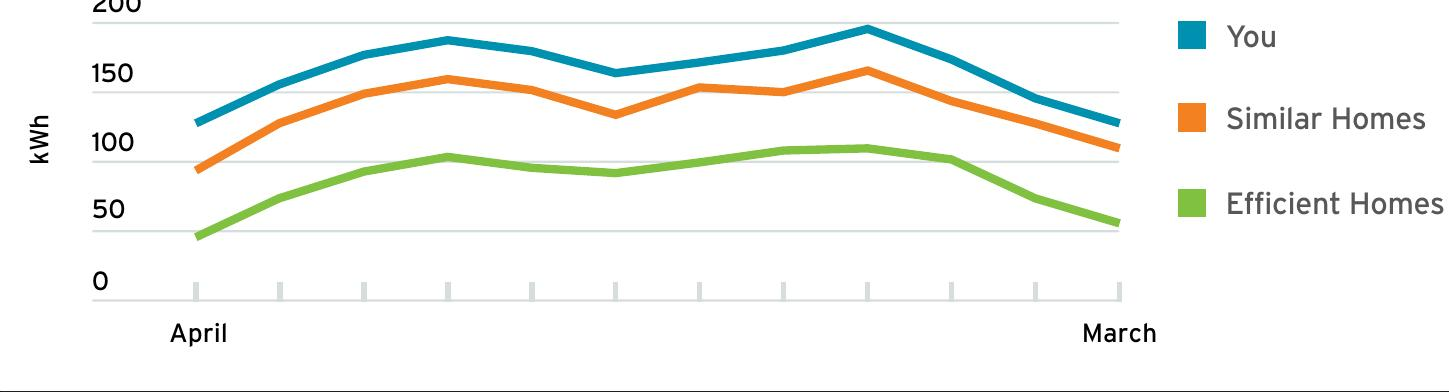

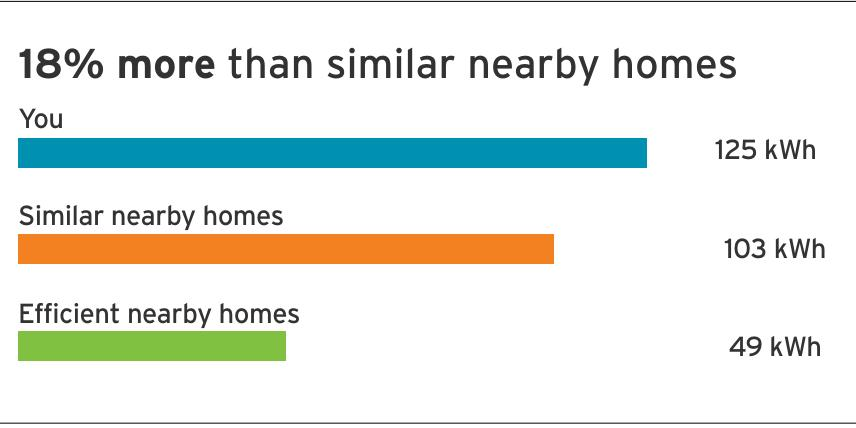

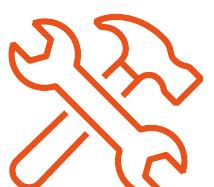

In [11]:
display_base64_image(images[7], 800)
display_base64_image(images[3], 400)
display_base64_image(images[9], 200)

---

## Text Summary and Image Caption

### Text Summary

For the text summary, I’ll use one of the Ollama models ([gemma2:2b](https://ollama.com/library/gemma2)) to summarize our text chunk with the help of one of the helper function `get_text_summaries`

In [12]:
text_summary = get_text_summaries(text_summary_model_name, texts)
text_summary

["This report analyzes electricity usage for a home with account number 954137 at 1627 Tulip Lane. The user's energy consumption is above typical levels and they can save up to 6% by doing full laundry loads.  The report provides tailored tips for energy saving, including caulking windows and doors, charging EVs overnight, adjusting thermostat settings, and pre-heating homes on cold days. It also highlights the importance of a home energy audit for further efficiency improvements. \n"]

### Image captioning

For image captioning, I’m using the HuggingFace model ([microsoft/git-base](https://huggingface.co/microsoft/git-base)). While it’s not the most advanced model for generating detailed descriptions, especially for complex visuals like charts, it performs reasonably well for basic captioning tasks. Some of the more capable image-to-text models, such as those from OpenAI, Amazon Bedrock, etc., offer better results but are currently behind a paywall.

In [13]:
captioner = pipeline(
    "image-to-text", 
    model=caption_model_name,
    device=0,
    use_fast=True
)
img_cap_list = []
for image in images:
    caption = captioner(image)[0]["generated_text"]
    img_cap_list.append(caption)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


Checking the caption on the displayed image of a chart earlier:

In [14]:
print(img_cap_list[7])
print(img_cap_list[3])
print(img_cap_list[9])

a line graph showing the line of the line.
what are the different types of homes in the area?
this is a picture of a hammer on a white background. i like the orange in the middle.


The captioning is kind of good but not good enough. For the purpose of getting a good retreival in the later steps lets just assume our captioning model did great and made this caption on the elecricity consumption graph:

In [15]:
img_cap_list[7] = "line graph showing electricity consumption"

## Setting Up the Vector and Document Store

Here, we use ChromaDB as the vector store and an in-memory store for the documents. Each summary and corresponding document will be assigned a doc_id to support retrieval later on. The embedding model used here for the vector embeddings is a version of the FlagEmbedding model ([BAAI/bge-large-en-v1.5](https://huggingface.co/BAAI/bge-large-en-v1.5)) which is focused on retrieval-augmented LLMs.

Vector and Document Databases in this use case are not persistently stored for the simplicity of this exercise but one can set them up to be store in a persistent and durable database or store.

In [16]:
embeddings = HuggingFaceEmbeddings(model_name='BAAI/bge-large-en-v1.5')

vector_store = Chroma(
    collection_name="rag_vector_store",
    embedding_function=embeddings,
)
store = InMemoryStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vector_store,
    docstore=store,
    id_key=id_key,
)

In [17]:
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summary)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(img_cap_list)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

---

## Retrieval from the Vector and Document Store using Query

Remember the caption we overwritten earlier? We now want to ask our vector-document store to display us our electricity consumption graph by fetching the top associated document based on the query.

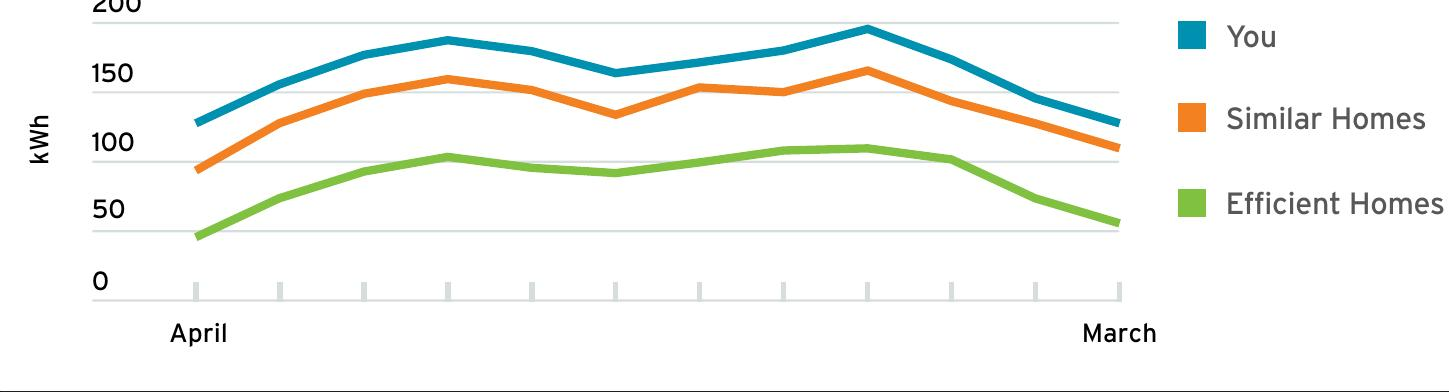

In [18]:
top_1_doc_from_query = retriever.invoke("Image of graph containing elecricity consumption?")[0]
display_base64_image(top_1_doc_from_query, 900)

Seems like we got our graph and the vector store is returning the top document associated with our query.

---

## Full RAG with Ollama (gemma3) Question and Answering

This defines a LangChain-style RAG pipeline for LLM question answering. It retrieves relevant documents from the vector-document store using the user’s question, parses the retrieved content (`parse_docs` helper function), constructs a prompt (`build_prompt` helper function), and sends it to an Ollama-hosted LLM ([gemma3](https://ollama.com/library/gemma3)). The final answer is then parsed into a string using `StrOutputParser()`. The use of `RunnableLambda` and `RunnablePassthrough()` allows flexible chaining of custom functions and inputs in the LangChain pipeline. I set the LLM's `temperature` param to 0 for the output to be consistent on repeated runs.

In [19]:
chain_llm_questions = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnableLambda(build_prompt) | OllamaLLM(
    model=ollama_model_name,
    temperature=0,
) | StrOutputParser()

In the section below we will be assessing the performance of our makeshift RAG solution with a few questions based on our PDF.

### Q1: What is the customer name, address and account id?

In [20]:
q1 = "What is the customer name, address, month cycle and account id?"
q1_model_resp = chain_llm_questions.invoke(q1)
display(Markdown(q1_model_resp))

Here’s the information based on the provided context:

*   **Customer Name:** JILL DOE
*   **Service Address:** 1627 Tulip Lane
*   **Month Cycle:** March
*   **Account ID:** 954137

---

Our RAG solution did well on this extract! The information perfectly aligns what is in the PDF

<img src="diagrams/customer.png" width="400"/>

### Q2: What is the category of my electric use?

In [21]:
q2 = "What is the category of my electric use?"
q2_model_resp = chain_llm_questions.invoke(q2)
display(Markdown(q2_model_resp))

Above typical use.

---

Our RAG solution also did well on this extract! The information perfectly aligns what is in the PDF

<img src="diagrams/category.png" width="300"/>

### Q3: What is my electricity usage this cycle in kWh?

In [22]:
q3 = "What is my electricity usage this cycle in kWh?"
q3_model_resp = chain_llm_questions.invoke(q3)
display(Markdown(q3_model_resp))

Your electric use: 18% more than similar nearby homes 125 kWh

---

Quite close but not quite. I was expecting here that the RAG solution would just say the customer consumed 125 kWh but it associated it to the similar nearby homes and our supposed consumption was 18% over 125 kWh. It seems that in this generation it hallucinated a bit.

<img src="diagrams/consumption.png" width="400"/>

### Q4: What are some tips for saving electricity?

In [23]:
q4 = "What are some tips for saving electricity?"
q4_model_resp = chain_llm_questions.invoke(q4)
display(Markdown(q4_model_resp))

Here are the tips for saving electricity based on the provided text:

*   Do full laundry loads.
*   Caulk windows and doors.
*   Charge your EV overnight (Rates are lower after 9pm).
*   Look for an Energy Star label.
*   Adjust thermostat settings.
*   Pre-heat your home on cold days.

---

Our RAG solution also performed well in this instance, it correctly matched the suggestions found in our PDF document. Notably, it retrieved a recommendation that wasn’t immediately visible in the displayed portion of the PDF: “Charge your EV overnight rates are lower after 9pm.”

<img src="diagrams/laundry.png" width="200"/><img src="diagrams/tips.png" width="500"/><img src="diagrams/audit.png" width="500"/>

In [24]:
ev_info = texts[0].text.replace("\n\n", " ")
ev_info = ev_info.replace("Charge your EV overnight Rates are lower after 9pm", "**Charge your EV overnight Rates are lower after 9pm**")
display(Markdown(ev_info))

Home Energy Report: electricity March report Account number: 954137 Service address: 1627 Tulip Lane Find your personalized analysis of your electrical energy use. Scan this code or log in to your account at franklinenergy.com. Dear JILL DOE, here is your usage analysis for March. Your electric use: Above typical use 18% more than similar nearby homes You Similar nearby homes 125 kWh Efficient nearby homes 103 kWh 49 kWh - Nearby homes are defined as... Other homes with electricity Homes within 9 km Homes within +/- 300 sq. ft. Nearby homes are based on fuel, distance and size. Square footage is collected from public information sources. Efficient nearby homes are the top 15 per cent efficient of similar-sized homes nearby. Monthly savings tip: Do full laundry loads. you to Wy, ts 6% : use. to save energy each month. over for more savings ideas. » Waiting until you have a full load to run your laundry can save up to 6% of your energy use. Watch this space for new ways to save energy each month. Turn over for more savings ideas. Your top three tailored energy-saving tips Caulk windows and doors Save money and energy **Charge your EV overnight Rates are lower after 9pm** Look for an Energy Star label Adjust thermostat settings Biggest energy saving option One of the biggest money-wasters in your home is drafty windows and doors. Caulking drafty areas is a simple DIY project that will pay off. Older model electric vehicle overnight for the very inefficient. You can make up whether your home the cost of a new Energy Star refrigerator in energy savings in just a few years. charging feature that you can use. 78° Set your smart thermostat to save more energy during high-cost hours. Pre-heat your home on cold days so that you can save more energy. Your annual electricity use compared with similar and efficient homes 200 You 150 h W k 100 Similar Homes 50 Efficient Homes 0 April March Save more this spring Evaluate your energy efficiency Reduce use and save money on your electric bill with these thorough tips, from the kitchen to the laundry room. (-T°o =] a Bring in the professionals! Assess your home's energy efficiency with a Home Energy Audit. S Visit co.my.xcelenergy.com/s/residential/tips. Visit xcelenergy.com/homeenergyaudit. Seven year savings is the money you can save after purchase, installation and maintenance costs, as well as rebates, have been accounted for. All estimates are based on standard net home proﬁle assumptions; to improve the accuracy and further customize your Xcel Energy savings plan, visit xcelenergy.com. For questions, contact us at 800.895.4999. All the costs of each action are estimates; check your savings plan for links to local contractors and suppliers who can provide actual costs. This Home Energy Report was prepared speciﬁcally for you, and is provided to help you get the most value from your Xcel Energy service. This report is available only to you, and is based on your usage proﬁle and other publicly available information. A message from Xcel Energy, Inc., ©2023. All Rights Reserved.

### Q5: How do I compare to other nearby homes in kwh consumption?

In [25]:
q5 = "How do I compare to other nearby homes in kwh consumption?"
q5_model_resp = chain_llm_questions.invoke(q5)
display(Markdown(q5_model_resp))

According to the report, you used 18% more than similar nearby homes. Your similar nearby homes used 125 kWh, and efficient nearby homes used 103 kWh and 49 kWh.

---

Our RAG solution came close, but it made a few key mistakes. It incorrectly attributed the 125 kWh usage to similar nearby homes, when in fact that was our actual consumption. Additionally, it misclassified the two comparison values: 103 kWh and 49 kWh. The 103 kWh figure should have been associated with similar nearby homes, while only the 49 kWh value corresponds to efficient nearby homes. Unfortunately, this instance also exhibited some hallucination in the output.

<img src="diagrams/consumption.png" width="400"/>

### Q6: Compared to other nearby homes am I using too much electricity?

In [26]:
q6 = "Compared to other nearby homes am I using too much electricity?"
q6_model_resp = chain_llm_questions.invoke(q6)
display(Markdown(q6_model_resp))

Yes, your electric use is 18% more than similar nearby homes.

---

At the very least, it still aligns with the overall message of the PDF, even if the exact figures weren’t correctly retrieved in the previous questions.

---

## Learnings, Challenges and Suggestions

### Learnings

I was first introduced to Retrieval-Augmented Generation (RAG) during my Natural Language Processing course in my master's program. Most of the implementations I worked on involved textual data using the `llama-index` framework and using data sourced from PDFs, arXiv articles, and plain text files. Until recently, I hadn't explored the extraction of images, figures, or charts. Learning to implement RAG using a new framework like `LangChain`, especially in a multimodal context that supports various document types beyond text has been a fresh and exciting experience for me.

### Challenges and Suggestions

This pipeline required handling multiple modalities, including:

- Text summarization
- Image captioning
- Text embedding for similarity
- LLM-based question answering

One of the key challenges was selecting the right open-source models. HuggingFace offers many options, but it’s often unclear which are best, especially for free use. Often requiring a lot of trial and errors to find a model that best fits the specific use case. Most tutorials rely on high-end models from providers like OpenAI and Amazon Bedrock to name a few, many of which are behind paywalls most especially for image based tasks.

I experimented with several models and combined them to achieve acceptable results. However, the LLM in the RAG setup was a bit prone to hallucinations. To improve this, fine-tuning, possibly with instruction tuning techniques like [Large-Scale Instruction Synthesis](https://arxiv.org/abs/2502.03843) could help reduce errors.

Lastly, extracting content from PDFs posed its own issues. While text extraction worked well, image and chart extraction using the `unstructured` python library (likely backed by Tesseract OCR) was less reliable and may require further tuning or alternative tools as the extracted images looked like they were cropped poorly.

# References

[1] [LangChain - Semi-structured and Multi-modal RAG](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)

[2] [How to retrieve using multiple vectors per document](https://python.langchain.com/docs/how_to/multi_vector/)

[3] [Multi-Modal RAG: A Practical Guide – Using vLLM to serve models for Multimodal Text Summarization, Table Processing, and Answer Synthesis](https://gautam75.medium.com/multi-modal-rag-a-practical-guide-99b0178c4fbb)

# Appendix

## Unit Test Setup

Checking the correctness of our RAG pipeline output based on their response vs. expected actual response. I will use of of the helper functions `query_and_validate` to do this which just takes in the two main strings (actual response and expected, plus a few logging params), ask an LLM ([gemma3](https://ollama.com/library/gemma3)) if they match enough resulting to `true`, `false` or  ``Can't determine``.

Using an LLM to evaluate another model’s output introduces its own layer of subjectivity, raising questions about how one should properly test such systems. But for our purposes, this approach is a practical alternative to brute-force string comparisons, which can be too rigid and fail to capture semantic similarity.

### Q1 Test

In [27]:
query_and_validate(
    model=ollama_model_name,
    question=q1,
    model_response=q1_model_resp,
    expected_response="""
Customer Name: JILL DOE
Service Address: 1627 Tulip Lane
Month Cycle: March
Account ID: 954137
""",
)

Question:
What is the customer name, address, month cycle and account id?

Expected Response: 
Customer Name: JILL DOE
Service Address: 1627 Tulip Lane
Month Cycle: March
Account ID: 954137

Actual Response: Here’s the information based on the provided context:

*   **Customer Name:** JILL DOE
*   **Service Address:** 1627 Tulip Lane
*   **Month Cycle:** March
*   **Account ID:** 954137
---
(Answer with 'true' or 'false') Does the actual response match the expected response? 

Response: true


True

### Q2 Test

In [28]:
query_and_validate(
    model=ollama_model_name,
    question=q2,
    model_response=q2_model_resp,
    expected_response="""Above Typical Use""",
)

Question:
What is the category of my electric use?

Expected Response: Above Typical Use
Actual Response: Above typical use.
---
(Answer with 'true' or 'false') Does the actual response match the expected response? 

Response: true


True

### Q3 Test

In [29]:
query_and_validate(
    model=ollama_model_name,
    question=q3,
    model_response=q3_model_resp,
    expected_response="Your electric use: is 125 kWh which is 18% more than similar nearby homes",
)

Question:
What is my electricity usage this cycle in kWh?

Expected Response: Your electric use: is 125 kWh which is 18% more than similar nearby homes
Actual Response: Your electric use: 18% more than similar nearby homes 125 kWh
---
(Answer with 'true' or 'false') Does the actual response match the expected response? 

Response: false


False

### Q4 Test

In [30]:
query_and_validate(
    model=ollama_model_name,
    question=q4,
    model_response=q4_model_resp,
    expected_response="""
    Do full laundry loads.
    Caulk windows and doors.
    Charge your EV overnight (Rates are lower after 9pm).
    Look for an Energy Star label.
    Adjust thermostat settings.
    Pre-heat your home on cold days.    
""",
)

Question:
What are some tips for saving electricity?

Expected Response: 
    Do full laundry loads.
    Caulk windows and doors.
    Charge your EV overnight (Rates are lower after 9pm).
    Look for an Energy Star label.
    Adjust thermostat settings.
    Pre-heat your home on cold days.    

Actual Response: Here are the tips for saving electricity based on the provided text:

*   Do full laundry loads.
*   Caulk windows and doors.
*   Charge your EV overnight (Rates are lower after 9pm).
*   Look for an Energy Star label.
*   Adjust thermostat settings.
*   Pre-heat your home on cold days.
---
(Answer with 'true' or 'false') Does the actual response match the expected response? 

Response: true


True

### Q5 Test

In [31]:
query_and_validate(
    model=ollama_model_name,
    question=q5,
    model_response=q5_model_resp,
    expected_response="""
    According to the report, you used 125 kWh which is 18% more than similar nearby homes. 
    Similar nearby homes used around 103 kWh and efficient nearby homes used 49 kWh""",
)

Question:
How do I compare to other nearby homes in kwh consumption?

Expected Response: 
    According to the report, you used 125 kWh which is 18% more than similar nearby homes. 
    Similar nearby homes used around 103 kWh and efficient nearby homes used 49 kWh
Actual Response: According to the report, you used 18% more than similar nearby homes. Your similar nearby homes used 125 kWh, and efficient nearby homes used 103 kWh and 49 kWh.
---
(Answer with 'true' or 'false') Does the actual response match the expected response? 

Response: false


False

### Q6 Test

In [32]:
query_and_validate(
    model=ollama_model_name,
    question=q6,
    model_response=q6_model_resp,
    expected_response="Yes, your electric use is 18% more than similar nearby homes.",
)

Question:
Compared to other nearby homes am I using too much electricity?

Expected Response: Yes, your electric use is 18% more than similar nearby homes.
Actual Response: Yes, your electric use is 18% more than similar nearby homes.
---
(Answer with 'true' or 'false') Does the actual response match the expected response? 

Response: true


True

### Performance 4/6

RAG Pipeline on this sample size of questions got 4 out of 6 questions quite accurately. Other 2 questions were close but exhibited some form of hallucination